# Install and Import Dependencies

In [1]:
!pip install tensorflow opencv-python mediapipe scikit-learn matplotlib tensorflowjs

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Bander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
!pip install pillow

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Bander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
!pip install pillow python-bidi arabic-reshaper

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Bander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [26]:
!pip install seaborn


Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Bander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [65]:
import cv2
import numpy as np
import os
import mediapipe as mp
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, regularizers, optimizers
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

from PIL import ImageFont, ImageDraw, Image
import arabic_reshaper
from bidi.algorithm import get_display
import time
import seaborn as sns

# Keypoints using MP Holistic

In [66]:
# Initialize MediaPipe Hands model
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Setup Folders for Collection

In [67]:
# Directory to save the data
alpha_dir = "C:\\Users\\Bander\\AppData\\Local\\Microsoft\\WindowsApps\\Senior_project\\Arabic_sign_language_detection\\alphabet_new"

# labels list
labels = ['aleff', 'baa', 'ta', 'thaa', 'jeem', 'haa', 'khaa', 'dal', 'thal', 'ra', 'zay', 
          'seen', 'sheen', 'saad', 'dhad', 'taa', 'dha', 'ain', 'ghain', 'fa', 'gaaf', 
          'kaaf', 'laam', 'meem', 'nun', 'ha', 'waw', 'yaa', 'la']

# Collect Keypoint Values for Training and Testing

In [21]:
# Number of samples per class
samples_per_class = 100

def capture_single_frame(label):
    cap = cv2.VideoCapture(0)
    count = len(os.listdir(os.path.join(alpha_dir, label)))
    print(f"Collecting data for '{label}' - Press 'q' to quit.")

    while count < samples_per_class:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)
        results = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])

                # Save the landmarks of the single frame as .npy file
                filename = os.path.join(alpha_dir, label, f"Shaima_{label}_{count}.npy")
                np.save(filename, landmarks)
                print(f"Saved {filename} ({count + 1}/{samples_per_class})")
                count += 1

        cv2.imshow("Alphabet Gesture Collection", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Create directories for each label if they don't exist
for label in labels:
    os.makedirs(os.path.join(alpha_dir, label), exist_ok=True)

# Capture data for all alphabets with a 10-second delay
for label in labels:
    print(f"Starting Alphabet collection for '{label}'")
    capture_single_frame(label)
    print(f"Completed collection for '{label}'. Waiting 10 seconds before the next label...")
    time.sleep(10)

print("Data collection complete!")

Starting Alphabet collection for 'aleff'
Saved C:\Users\Bander\AppData\Local\Microsoft\WindowsApps\Senior_project\Arabic_sign_language_detection\alphabet_new\aleff\Shaima_aleff_0.npy (1/100)
Saved C:\Users\Bander\AppData\Local\Microsoft\WindowsApps\Senior_project\Arabic_sign_language_detection\alphabet_new\aleff\Shaima_aleff_1.npy (2/100)
Saved C:\Users\Bander\AppData\Local\Microsoft\WindowsApps\Senior_project\Arabic_sign_language_detection\alphabet_new\aleff\Shaima_aleff_2.npy (3/100)
Saved C:\Users\Bander\AppData\Local\Microsoft\WindowsApps\Senior_project\Arabic_sign_language_detection\alphabet_new\aleff\Shaima_aleff_3.npy (4/100)
Saved C:\Users\Bander\AppData\Local\Microsoft\WindowsApps\Senior_project\Arabic_sign_language_detection\alphabet_new\aleff\Shaima_aleff_4.npy (5/100)
Saved C:\Users\Bander\AppData\Local\Microsoft\WindowsApps\Senior_project\Arabic_sign_language_detection\alphabet_new\aleff\Shaima_aleff_5.npy (6/100)
Saved C:\Users\Bander\AppData\Local\Microsoft\WindowsApps\S

# Check balance data

C:\Users\Bander\AppData\Local\Temp\ipykernel_19332\921840944.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_classes, y=sorted_counts, palette='muted')


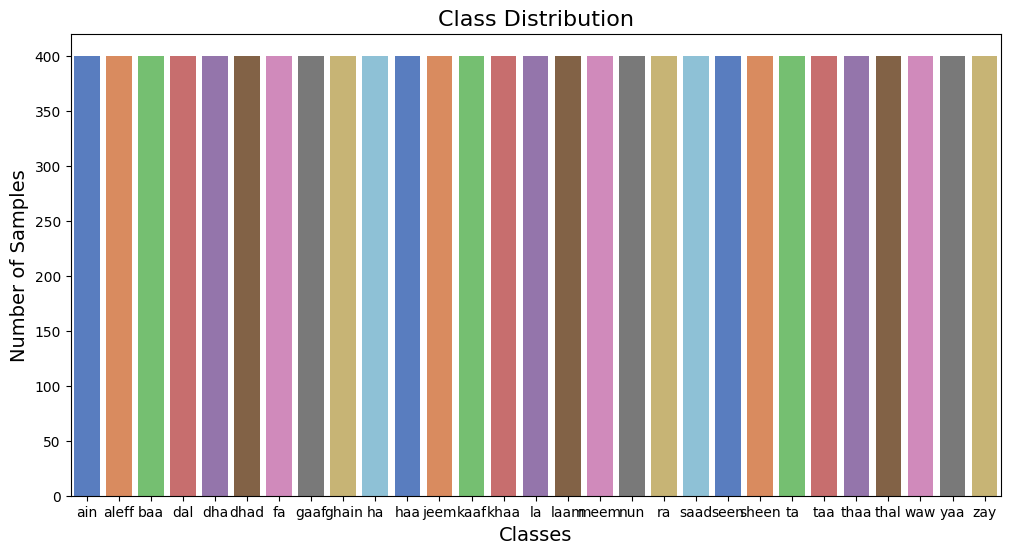

In [68]:
class_counts = {cls: len(os.listdir(os.path.join(alpha_dir, cls))) for cls in os.listdir(alpha_dir)}

sorted_classes = sorted(class_counts.keys())
sorted_counts = [class_counts[cls] for cls in sorted_classes]

plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_classes, y=sorted_counts, palette='muted')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.title('Class Distribution', fontsize=16)
plt.show()

In [69]:
class_counts_array = np.array(sorted_counts)
mean = np.mean(class_counts_array)
std_dev = np.std(class_counts_array)
cv = std_dev / mean

print(f"Mean: {mean}, Standard Deviation: {std_dev}, Coefficient of Variation: {cv:.2f}")

Mean: 400.0, Standard Deviation: 0.0, Coefficient of Variation: 0.00


# Preprocess Data and Create Labels and Features

In [70]:
label_map = {label:num for num, label in enumerate(labels)}

In [71]:
label_map

{'aleff': 0,
 'baa': 1,
 'ta': 2,
 'thaa': 3,
 'jeem': 4,
 'haa': 5,
 'khaa': 6,
 'dal': 7,
 'thal': 8,
 'ra': 9,
 'zay': 10,
 'seen': 11,
 'sheen': 12,
 'saad': 13,
 'dhad': 14,
 'taa': 15,
 'dha': 16,
 'ain': 17,
 'ghain': 18,
 'fa': 19,
 'gaaf': 20,
 'kaaf': 21,
 'laam': 22,
 'meem': 23,
 'nun': 24,
 'ha': 25,
 'waw': 26,
 'yaa': 27,
 'la': 28}

In [72]:
X, y = [], []
for label in labels:
    class_dir = os.path.join(alpha_dir, label)
    for file in os.listdir(class_dir):
        if file.endswith(".npy"):
            landmarks = np.load(os.path.join(class_dir, file))
            X.append(landmarks)
            y.append(labels.index(label))

In [73]:
X = np.array(X)

In [74]:
y = np.array(y)

In [75]:
# Reshape data for LSTM: (samples, timesteps, features)
X = X.reshape(X.shape[0], 1, X.shape[1])  # each sequence is just one timestep (using static data)

In [76]:
# Split data into train (80%) and temp (20% for validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
# Split temp into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [78]:
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 9280 samples
Validation set: 1160 samples
Test set: 1160 samples


**Plotting class distribution for training, validation, and test sets**

In [79]:
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

# If class labels are integers, map them back to class names
unique_train_classes = [labels[i] for i in range(len(train_counts))]
unique_val_classes = [labels[i] for i in range(len(val_counts))]
unique_test_classes = [labels[i] for i in range(len(test_counts))]

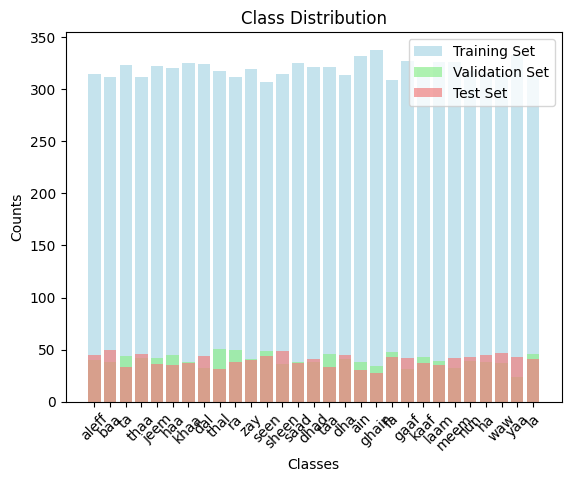

In [80]:
# Training set distribution
plt.bar(unique_train_classes, train_counts, color='lightblue', alpha=0.7, label="Training Set")
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Distribution')
plt.xticks(rotation=45)

# Validation set distribution
plt.bar(unique_val_classes, val_counts, color='lightgreen', alpha=0.7, label="Validation Set")

# Test set distribution
plt.bar(unique_test_classes, test_counts, color='lightcoral', alpha=0.7, label="Test Set")

plt.legend()
plt.show()


# Build and Train LSTM Neural Network

In [81]:
model_1 = Sequential([
    # First LSTM layer with 128 units
    layers.LSTM(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), 
                return_sequences=True),
    layers.Dropout(0.3),
    layers.BatchNormalization(),

    # Second LSTM layer with 64 units
    layers.LSTM(64, activation='tanh', return_sequences=False),
    layers.Dropout(0.3),
    layers.BatchNormalization(),

    # Dense layer with 128 units
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.BatchNormalization(),

    # Output layer with softmax activation
    layers.Dense(len(labels), activation='softmax')
])


C:\Users\Bander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [82]:
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [83]:
history_data =model_1.fit(X_train, y_train, epochs=300, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.0576 - loss: 3.7533 - val_accuracy: 0.1000 - val_loss: 3.1279
Epoch 2/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3602 - loss: 1.9483 - val_accuracy: 0.6276 - val_loss: 1.3828
Epoch 3/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5912 - loss: 1.1755 - val_accuracy: 0.7897 - val_loss: 0.6173
Epoch 4/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6712 - loss: 0.9243 - val_accuracy: 0.8457 - val_loss: 0.5331
Epoch 5/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7204 - loss: 0.7859 - val_accuracy: 0.7922 - val_loss: 0.5873
Epoch 6/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7371 - loss: 0.7210 - val_accuracy: 0.8828 - val_loss: 0.4124
Epoch 7/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7736 - loss: 0.6466 - val_accuracy: 0.7810 - val_loss: 0.5697
Epoch 8/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7740 - loss: 0.6316 - val_accu

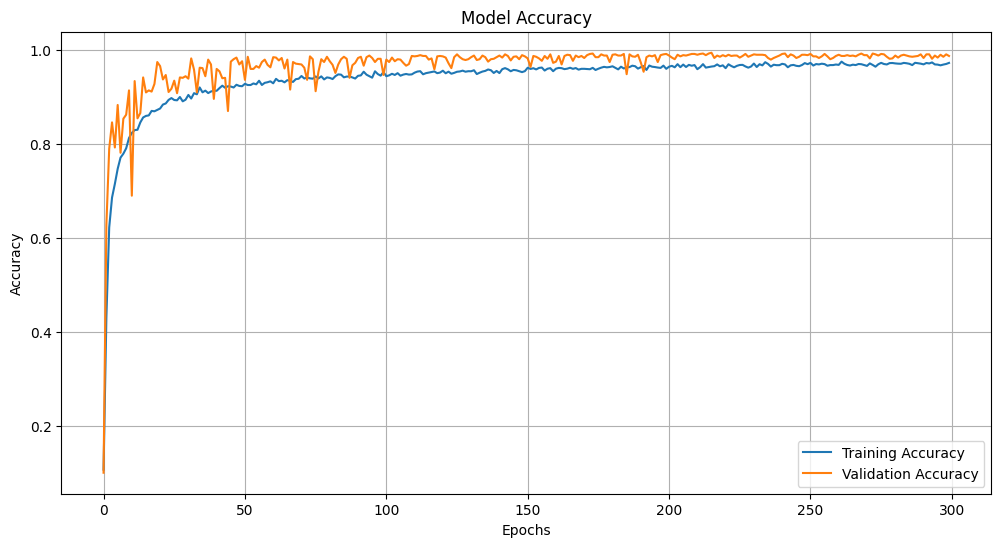

In [84]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_data.history['accuracy'], label='Training Accuracy')
plt.plot(history_data.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [86]:
model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 128)         │        98,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481,881 (1.84 MB)

 Trainable params: 160,413 (626.61 KB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 320,828 (1.22 MB)

In [87]:
model_1.save("C:\\Users\\Bander\\AppData\\Local\\Microsoft\\WindowsApps\\Senior_project\\Arabic_sign_language_detection\\model_1_alpha.h5")

# LSTM Evaluation

In [88]:
# Make predictions
y_pred = model_1.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


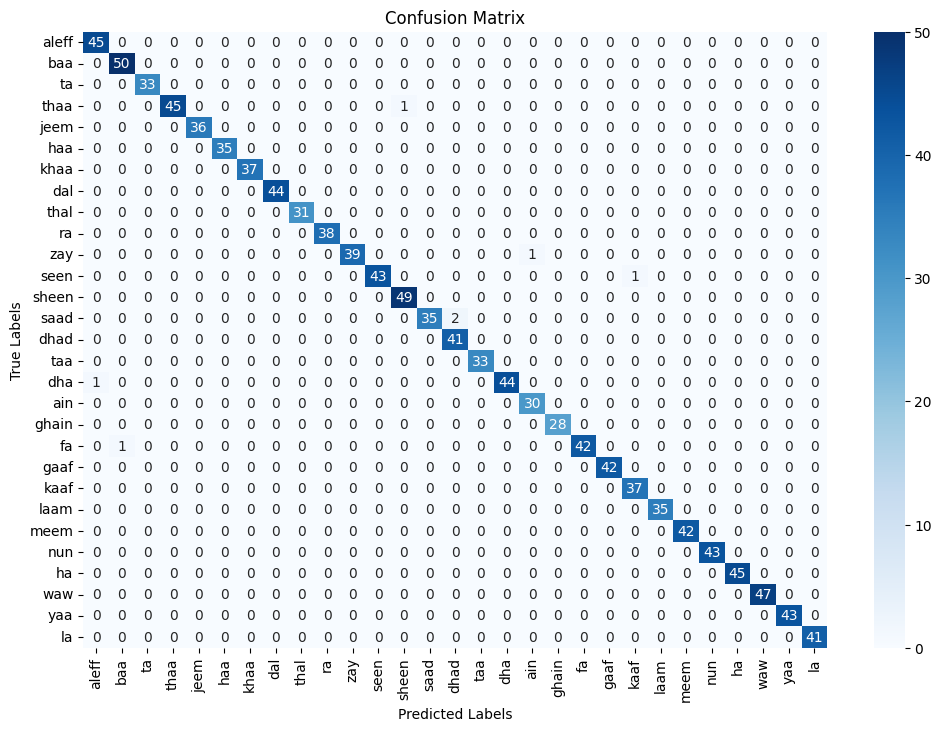

In [89]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [90]:
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       0.98      1.00      0.99        50
           2       1.00      1.00      1.00        33
           3       1.00      0.98      0.99        46
           4       1.00      1.00      1.00        36
           5       1.00      1.00      1.00        35
           6       1.00      1.00      1.00        37
           7       1.00      1.00      1.00        44
           8       1.00      1.00      1.00        31
           9       1.00      1.00      1.00        38
          10       1.00      0.97      0.99        40
          11       1.00      0.98      0.99        44
          12       0.98      1.00      0.99        49
          13       1.00      0.95      0.97        37
          14       0.95      1.00      0.98        41
          15       1.00      1.00      1.00        33
          16       1.00      0.98      0.99        45
    

# LSTM Realtime Test

In [91]:
# Load the trained LSTM model
model_1 = tf.keras.models.load_model('C:\\Users\\Bander\\AppData\\Local\\Microsoft\\WindowsApps\\Senior_project\\Arabic_sign_language_detection\\model_1_alpha.h5')

# Labels for your classes in Arabic
labels = ['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', "ص", "ض", "ط", "ظ", "ع", "غ", "ف", "ق", "ك", "ل", "م", 'ن', "ه", "و", "ي", "لا"]

# Capture data using webcam
cap = cv2.VideoCapture(0)
print("Press 'q' to quit.")

# Load Arabic font
font_path = "C:\\Users\\Bander\\AppData\\Local\\Microsoft\\WindowsApps\\Senior_project\\Arabic_sign_language_detection\\Arial_Bold.ttf"
font = ImageFont.truetype(font_path, 60)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    results = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Check if a hand is detected
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Extract 21 landmarks (x, y, z)
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])

            # Convert landmarks to NumPy array and reshape to match model input (1, 1, 63)
            landmarks = np.array(landmarks).reshape(1, 1, 63)  # Add batch and timestep dimensions

            # Make the prediction using the trained model
            prediction = model_1.predict(landmarks)
            predicted_label = labels[np.argmax(prediction)]
            prediction_text = f"الحرف: {predicted_label}"

            # Reshape the Arabic text
            reshaped_text = arabic_reshaper.reshape(prediction_text)

            # Get display version for right-to-left text
            display_text = get_display(reshaped_text)

            # Convert the frame to a PIL Image to draw Arabic text
            pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            draw = ImageDraw.Draw(pil_img)

            # Get the bounding box of the text and calculate position to align text from right to left
            text = display_text
            bbox = draw.textbbox((0, 0), text, font=font)
            text_width = bbox[2] - bbox[0]
            text_height = bbox[3] - bbox[1]

            # Position the text from the right (for right-to-left reading)
            text_x = (frame.shape[1] - text_width) // 2  # Center horizontally
            text_y = 10  # Small padding from the top

            # Draw the Arabic text on the frame
            draw.text((text_x, text_y), text, font=font, fill=(0, 0, 0))

            # Convert back to OpenCV format
            frame = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

    else:
        # Optionally, clear the text when no hand is detected
        no_hand_text = "ضع يدك في الإطار"
        reshaped_no_hand_text = arabic_reshaper.reshape(no_hand_text)
        display_no_hand_text = get_display(reshaped_no_hand_text)

        pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        draw = ImageDraw.Draw(pil_img)

        # Display "no hand detected" text
        text = display_no_hand_text
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_x = (frame.shape[1] - text_width) // 2
        text_y = 10

        draw.text((text_x, text_y), text, font=font, fill=(255, 0, 0))  # Red text for warning
        frame = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

    # Show the frame with prediction
    cv2.imshow("Real-Time Hand Gesture Recognition", frame)

    # Exit when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Press 'q' to quit.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39

# Build and train GRU Model 

In [92]:
model_1_gru = Sequential([
    # First GRU layer with 128 units
    layers.GRU(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), 
               return_sequences=True),
    layers.Dropout(0.3),
    layers.BatchNormalization(),

    # Second GRU layer with 64 units
    layers.GRU(64, activation='tanh', return_sequences=False),
    layers.Dropout(0.3),
    layers.BatchNormalization(),

    # Dense layer with 128 units
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.BatchNormalization(),

    # Output layer with softmax activation
    layers.Dense(len(labels), activation='softmax')
])

C:\Users\Bander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [93]:
model_1_gru.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [94]:
history_data1 = model_1_gru.fit(X_train, y_train, epochs=300, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.0692 - loss: 3.6631 - val_accuracy: 0.2138 - val_loss: 2.8247
Epoch 2/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3757 - loss: 1.8573 - val_accuracy: 0.5483 - val_loss: 1.2750
Epoch 3/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5734 - loss: 1.1754 - val_accuracy: 0.7310 - val_loss: 0.7221
Epoch 4/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6729 - loss: 0.9058 - val_accuracy: 0.7517 - val_loss: 0.7131
Epoch 5/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7141 - loss: 0.7837 - val_accuracy: 0.8578 - val_loss: 0.4487
Epoch 6/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7377 - loss: 0.7246 - val_accuracy: 0.8009 - val_loss: 0.4742
Epoch 7/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7600 - loss: 0.6538 - val_accuracy: 0.8172 - val_loss: 0.4684
Epoch 8/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7684 - loss: 0.6522 - val_acc

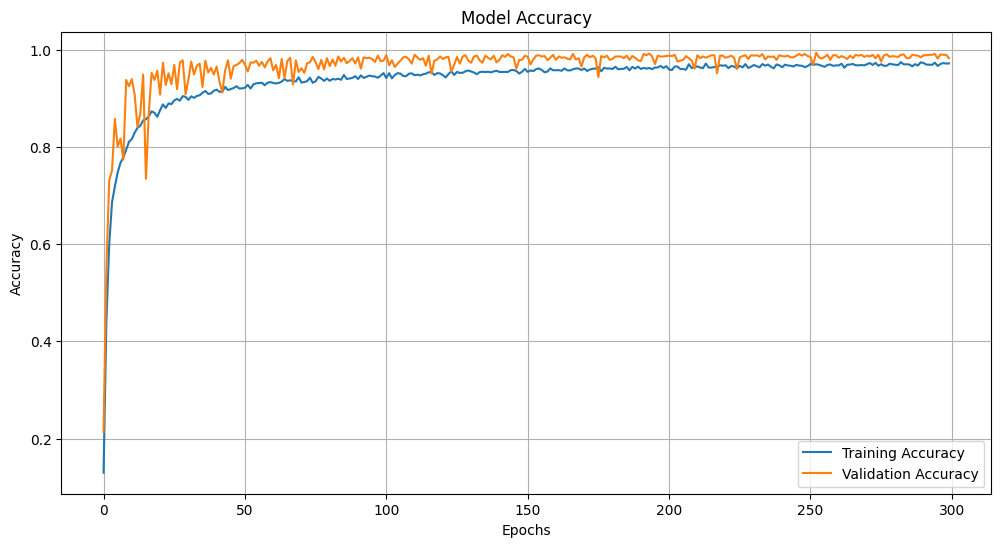

In [95]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_data1.history['accuracy'], label='Training Accuracy')
plt.plot(history_data1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [96]:
model_1_gru.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 1, 128)         │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 372,825 (1.42 MB)

 Trainable params: 124,061 (484.61 KB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 248,124 (969.24 KB)

In [97]:
model_1_gru.save("C:\\Users\\Bander\\AppData\\Local\\Microsoft\\WindowsApps\\Senior_project\\Arabic_sign_language_detection\\model_2_alpha.h5")

# GRU Evaluation

In [98]:
# Make predictions
y_pred = model_1_gru.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


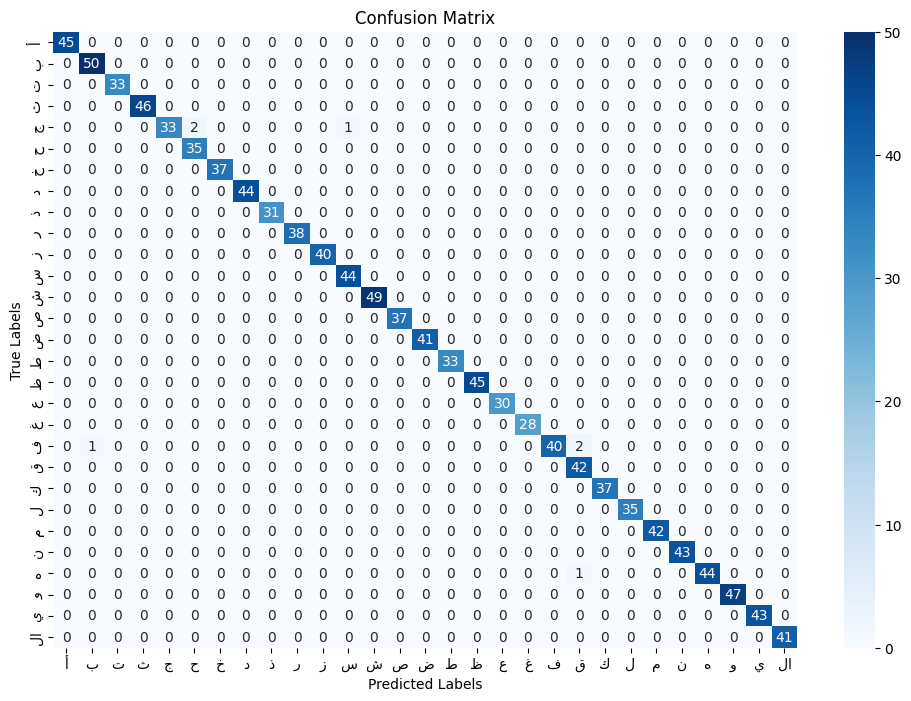

In [99]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [100]:
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.98      1.00      0.99        50
           2       1.00      1.00      1.00        33
           3       1.00      1.00      1.00        46
           4       1.00      0.92      0.96        36
           5       0.95      1.00      0.97        35
           6       1.00      1.00      1.00        37
           7       1.00      1.00      1.00        44
           8       1.00      1.00      1.00        31
           9       1.00      1.00      1.00        38
          10       1.00      1.00      1.00        40
          11       0.98      1.00      0.99        44
          12       1.00      1.00      1.00        49
          13       1.00      1.00      1.00        37
          14       1.00      1.00      1.00        41
          15       1.00      1.00      1.00        33
          16       1.00      1.00      1.00        45
    

In [101]:
# Load the trained LSTM model
model_1_gru = tf.keras.models.load_model('C:\\Users\\Bander\\AppData\\Local\\Microsoft\\WindowsApps\\Senior_project\\Arabic_sign_language_detection\\model_2_alpha.h5')

# Labels for your classes in Arabic
labels = ['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', "ص", "ض", "ط", "ظ", "ع", "غ", "ف", "ق", "ك", "ل", "م", 'ن', "ه", "و", "ي", "لا"]

# Capture data using webcam
cap = cv2.VideoCapture(0)
print("Press 'q' to quit.")

# Load Arabic font
font_path = "C:\\Users\\Bander\\AppData\\Local\\Microsoft\\WindowsApps\\Senior_project\\Arabic_sign_language_detection\\Arial_Bold.ttf"
font = ImageFont.truetype(font_path, 60)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    results = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Check if a hand is detected
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Extract 21 landmarks (x, y, z)
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])

            # Convert landmarks to NumPy array and reshape to match model input (1, 1, 63)
            landmarks = np.array(landmarks).reshape(1, 1, 63)  # Add batch and timestep dimensions

            # Make the prediction using the trained model
            prediction = model_1_gru.predict(landmarks)
            predicted_label = labels[np.argmax(prediction)]
            prediction_text = f"الحرف: {predicted_label}"

            # Reshape the Arabic text
            reshaped_text = arabic_reshaper.reshape(prediction_text)

            # Get display version for right-to-left text
            display_text = get_display(reshaped_text)

            # Convert the frame to a PIL Image to draw Arabic text
            pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            draw = ImageDraw.Draw(pil_img)

            # Get the bounding box of the text and calculate position to align text from right to left
            text = display_text
            bbox = draw.textbbox((0, 0), text, font=font)
            text_width = bbox[2] - bbox[0]
            text_height = bbox[3] - bbox[1]

            # Position the text from the right (for right-to-left reading)
            text_x = (frame.shape[1] - text_width) // 2  # Center horizontally
            text_y = 10  # Small padding from the top

            # Draw the Arabic text on the frame
            draw.text((text_x, text_y), text, font=font, fill=(0, 0, 0))

            # Convert back to OpenCV format
            frame = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

    else:
        # Optionally, clear the text when no hand is detected
        no_hand_text = "ضع يدك في الإطار"
        reshaped_no_hand_text = arabic_reshaper.reshape(no_hand_text)
        display_no_hand_text = get_display(reshaped_no_hand_text)

        pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        draw = ImageDraw.Draw(pil_img)

        # Display "no hand detected" text
        text = display_no_hand_text
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_x = (frame.shape[1] - text_width) // 2
        text_y = 10

        draw.text((text_x, text_y), text, font=font, fill=(255, 0, 0))  # Red text for warning
        frame = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

    # Show the frame with prediction
    cv2.imshow("Real-Time Hand Gesture Recognition", frame)

    # Exit when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Press 'q' to quit.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39